In [ ]:
from google.colab import files
uploaded=files.upload()

Saving Housing.csv to Housing.csv


In [ ]:
import numpy as np
import pandas as pd


In [ ]:
data=pd.read_csv('Housing.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
y=data['price'].copy()
X=data.drop('price',axis=1).copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'prefarea', 'furnishingstatus']


numerical_transformer = StandardScaler()
X_train[numerical_cols] = numerical_transformer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_transformer.transform(X_test[numerical_cols])
X_val[numerical_cols] = numerical_transformer.transform(X_val[numerical_cols])

categorical_transformer = OneHotEncoder(sparse_output=False)
X_train_encoded = categorical_transformer.fit_transform(X_train[categorical_cols])
X_test_encoded = categorical_transformer.transform(X_test[categorical_cols])
X_val_encoded = categorical_transformer.transform(X_val[categorical_cols])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=categorical_transformer.get_feature_names_out(categorical_cols), index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=categorical_transformer.get_feature_names_out(categorical_cols), index=X_test.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=categorical_transformer.get_feature_names_out(categorical_cols), index=X_val.index)
X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)
X_val = X_val.drop(columns=categorical_cols).join(X_val_encoded)

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    # Train evaluation
    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r2 = r2_score(y_train, train_pred)

    # Validation evaluation
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_r2 = r2_score(y_val, val_pred)

    # Test evaluation
    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)

    return train_rmse, train_r2, val_rmse, val_r2, test_rmse, test_r2


In [ ]:
# 1. Linear Regression
lr = LinearRegression()
lr_results = evaluate_model(lr, X_train, y_train, X_val, y_val, X_test, y_test)

# 2. Random Forest
rf = RandomForestRegressor(random_state=42)
rf_results = evaluate_model(rf, X_train, y_train, X_val, y_val, X_test, y_test)

# 3. Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_results = evaluate_model(gb, X_train, y_train, X_val, y_val, X_test, y_test)

# Comparing results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train RMSE': [lr_results[0], rf_results[0], gb_results[0]],
    'Train R²': [lr_results[1], rf_results[1], gb_results[1]],
    'Validation RMSE': [lr_results[2], rf_results[2], gb_results[2]],
    'Validation R²': [lr_results[3], rf_results[3], gb_results[3]],
    'Test RMSE': [lr_results[4], rf_results[4], gb_results[4]],
    'Test R²': [lr_results[5], rf_results[5], gb_results[5]]
})

print(results)


               Model     Train RMSE  Train R²  Validation RMSE  Validation R²  \
0  Linear Regression  981751.180202  0.693199     1.336980e+06       0.586188   
1      Random Forest  397427.626725  0.949723     1.379318e+06       0.559565   
2  Gradient Boosting  625916.729260  0.875294     1.242725e+06       0.642478   

      Test RMSE   Test R²  
0  1.121839e+06  0.706844  
1  1.318334e+06  0.595155  
2  1.295560e+06  0.609022  


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

gb = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
best_gb = GradientBoostingRegressor(
    subsample=0.8,
    n_estimators=100,
    min_samples_split=5,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

best_gb.fit(X_train, y_train)

#best_gb = GradientBoostingRegressor(random_state=42)
best_gb_results = evaluate_model(best_gb, X_train, y_train, X_val, y_val, X_test, y_test)

print("Optimized GB results:",best_gb_results)


Optimized GB results: (np.float64(729428.1864604068), 0.8306368133307012, np.float64(1238218.513857514), 0.6450661079065674, np.float64(1302723.318843407), 0.6046866029831011)


In [ ]:
import joblib

# Save the best model
joblib.dump(best_gb, "best_gb_model.pkl")

# Load for inference
loaded_model = joblib.load("best_gb_model.pkl")

# Evaluate on test data
y_pred = loaded_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)

Test RMSE: 1302723.318843407
Test R²: 0.6046866029831011


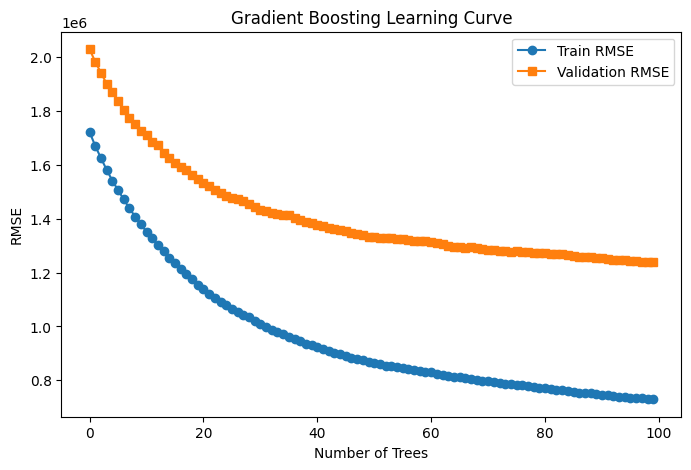

In [ ]:
import matplotlib.pyplot as plt

train_errors = [mean_squared_error(y_train, y_pred) for y_pred in best_gb.staged_predict(X_train)]
val_errors = [mean_squared_error(y_val, y_pred) for y_pred in best_gb.staged_predict(X_val)]

train_rmse = np.sqrt(train_errors)
val_rmse = np.sqrt(val_errors)

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label="Train RMSE", marker="o")
plt.plot(val_rmse, label="Validation RMSE", marker="s")
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Gradient Boosting Learning Curve")
plt.legend()
plt.show()
